# **Imports**

In [0]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import sklearn as skl
from sklearn.model_selection import train_test_split
import librosa
import os
import pickle

import torch
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import math
from tqdm import tqdm
import sys

# Classes

## **RBM**

In [0]:
BATCH_SIZE = 64

class RBM(nn.Module):
    '''
    Classe RBM (Restricted Bolzman Machine)
    Modifé à partir de l'implémentaion de mehulrastogi sur GitHub (https://github.com/mehulrastogi/Deep-Belief-Network-pytorch)
    '''

    def __init__(self,
                visible_units=50,
                hidden_units = 50,
                k=2,
                learning_rate=1e-3,
                momentum_coefficient = 0.5,
                learning_rate_decay = False,
                xavier_init = False,
                increase_to_cd_k = False,
                use_gpu = False,
                _activation = 'sigmoid',
                batch_size = 16
                ):
        '''
        Définition du modèle
        '''
        super(RBM,self).__init__()
        self.desc = "RBM"

        self.visible_units = visible_units
        self.hidden_units = hidden_units
        self.k = k
        self.learning_rate = learning_rate
        self.momentum_coefficient = momentum_coefficient
        self.learning_rate_decay = learning_rate_decay
        self.xavier_init = xavier_init
        self.increase_to_cd_k = increase_to_cd_k
        self.use_gpu = use_gpu
        self._activation = _activation
        self.batch_size = batch_size


        # Initialization
        self.W = torch.randn(self.visible_units, self.hidden_units) / math.sqrt(self.visible_units)
        self.h_bias = torch.randn(self.hidden_units) / math.sqrt(self.hidden_units) #hidden layer bias
        self.v_bias = torch.randn(self.visible_units) / math.sqrt(self.visible_units)#visible layer bias

        self.W_momentum = torch.zeros(self.visible_units, self.hidden_units)
        self.h_bias_momentum = torch.zeros(self.hidden_units)
        self.v_bias_momentum = torch.zeros(self.visible_units)

    def activation(self, X):
      """
      Obtenir l'activation de données selon l'activation définie
      :param X: données à passer à la fonction d'activation
      """
      if self._activation == 'sigmoid':
        return torch.sigmoid(X)
      elif self._activation == 'tanh':
        return torch.tanh(X)
      elif self._activation == 'relu':
        return torch.relu(X)
      else:
        raise ValueError("Invalid Activation Function")

    def to_hidden(self ,X):
        '''
        Prédire la sortie à partir de l'entrée (X)
        :param X: probabilités visibles (torch.tensor de taille (n_exemples, n_features))
        :return 
            X_prob : probabilités de sortie
            sample_X_prob : Échantillonage de Gibbs (1 ou 0) selon les valeurs
        '''
        X_prob = torch.matmul(X,self.W)
        X_prob = torch.add(X_prob, self.h_bias)#W.x + c
        X_prob  = self.activation(X_prob)

        sample_X_prob = self.sampling(X_prob)

        return X_prob,sample_X_prob

    def to_visible(self,X):
        '''
        Reconstruire l'entrée à partir de la sortie et échantillonage
        :param X : probabilités de sortie
        :return 
            X_prob : probabilités de l'entrée reconstruite
            sample_X_prob : Échantillonage de Gibbs (1 ou 0) selon les valeurs
        '''
        # computing hidden activations and then converting into probabilities
        X_prob = torch.matmul(X ,self.W.transpose( 0 , 1) )
        X_prob = torch.add(X_prob , self.v_bias)
        X_prob = self.activation(X_prob)

        sample_X_prob = self.sampling(X_prob)

        return X_prob,sample_X_prob

    def sampling(self,prob):
        '''
        Échantillogane de Bernoulli selon la probabilité
        :param prob : probabilité à utiliser
        :return s : résulat de l'échantillogane selon la distribution de Bernoulli
        '''
        s = torch.distributions.Bernoulli(prob).sample()
        return s

    def reconstruction_error(self , data):
        '''
        Calcul l'erreur de reconstruction depuis les données
        '''
        return self.contrastive_divergence(data, False)

    def reconstruct(self , X,n_gibbs):
        '''
        Reconstruction à partir de l'entrée (allé-retour)
        :param X : données en entrée
        :return 
          Probabilités des valeurs reconstruites
          Échantillonage (0 ou 1) selon les valeurs
        '''
        v = X
        for i in range(n_gibbs):
            prob_h_,h = self.to_hidden(v)
            prob_v_,v = self.to_visible(prob_h_)
        return prob_v_,v


    def contrastive_divergence(self, input_data ,training = True):
      """
      Applique l'algorithme de "contrastive_divergence" pour obtimiser les paramètres
      :param input_data : données en entrée (données d'entrainement)
      :param training : doit entrainer ou non
      :return error : Erreur de prédiction (Loss)
      """
        # positive phase
        positive_hidden_probabilities,positive_hidden_act  = self.to_hidden(input_data)

        # calculating W via positive side
        positive_associations = torch.matmul(input_data.t() , positive_hidden_act)

        # negetive phase
        hidden_activations = positive_hidden_act
        for i in range(self.k):
            visible_probabilities , _ = self.to_visible(hidden_activations)
            hidden_probabilities,hidden_activations = self.to_hidden(visible_probabilities)

        negative_visible_probabilities = visible_probabilities
        negative_hidden_probabilities = hidden_probabilities

        # calculating W via negative side
        negative_associations = torch.matmul(negative_visible_probabilities.t() , negative_hidden_probabilities)


        # Update parameters
        if(training):
          self.W_momentum *= self.momentum_coefficient
          self.W_momentum += (positive_associations - negative_associations)

          self.v_bias_momentum *= self.momentum_coefficient
          self.v_bias_momentum += torch.sum(input_data - negative_visible_probabilities, dim = 0)

          self.h_bias_momentum *= self.momentum_coefficient
          self.h_bias_momentum += torch.sum(positive_hidden_probabilities - negative_hidden_probabilities, dim = 0)

          self.W += self.W_momentum * self.learning_rate / self.batch_size
          self.v_bias += self.v_bias_momentum * self.learning_rate / self.batch_size
          self.h_bias += self.h_bias_momentum * self.learning_rate / self.batch_size

        # Compute reconstruction error
        error = torch.mean(torch.sum((input_data - negative_visible_probabilities)**2 , 1))
        return error


    def forward(self,input_data):
        """
        Équivalent à appeler RBN.to_hidden(input_data)
        """
        return  self.to_hidden(input_data)

    def step(self,input_data):
        """
        Appele contrastive_divergence. Utiliser lors de l'entrainement
        """
        return self.contrastive_divergence(input_data , True)


    def train(self,train_data , num_epochs = 50,batch_size=20):
      """
      Entrainement du RBM
      :param train_data : données pour l'entrainement
      :param num_epochs : nombre d'époques pour l'entrainement
      :param batch_size : taille des batchs pour l'entrainement
      """
      self.batch_size = batch_size
      if(isinstance(train_data ,torch.utils.data.DataLoader)):
        train_loader = train_data
      else:
        train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
      
      n_batches = int(len(train_loader))
      for epoch in range(num_epochs):
        epoch_err = 0.0
        # print(n_batches)
        cost_ = torch.FloatTensor(n_batches , 1)
        for i,(batch,_) in tqdm(enumerate(train_loader),ascii=True, desc="RBM fitting", file=sys.stdout):
          batch = batch.view(len(batch) , self.visible_units)
          if(self.use_gpu):
            batch = batch.cuda()
          cost_[i] = self.step(batch, num_epochs)
        print("Epoch:{} ,avg_cost = {} ,std_cost = {} ".format(epoch, torch.mean(cost_), torch.std(cost_)))
      return
      
    def extract_features(self, test_dataset):
      """
      Extraction des sorties du RBM à partir des données du test_dataset
      :param test_dataset : DataLoader des données de test
      :return 
        test_features: activations du RBM
        test_labels : Étiquettes associées aux exemples
      """
      if(isinstance(test_dataset, torch.utils.data.DataLoader)):
        test_loader = test_dataset
      else:
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = self.batch_size)
      
      test_features = []
      test_labels = []

      for i,(batch,labels) in enumerate(test_loader):
        batch = batch.view(len(batch), self.visible_unites)

        if self.use_gpu:
          batch = batch.cuda()
        test_labels.append(labels.numpy())
        test_features.append((self.to_hidden(batch)[0].numpy(), self.to_hidden(batch)[1].numpy()))
      return(np.array(test_features), np.array(test_labels))


##**DBN**

In [0]:
class DBN(nn.Module):
	def __init__(self,
				 visible_units=513,  # Taille de la couche d'entrée
				 hidden_units=[50, 50, 50],  # Couches cachées
				 n_outputs = 10,
				 k=2,
				 learning_rate=1e-3,
				 momentum_coefficient = 0.9,
				 learning_rate_decay=False,
				 xavier_init=False,
				 increase_to_cd_k=False,
				 use_gpu=False,
				 _activation = 'sigmoid'
				 ):
		"""
		:param visible_units: Taille de la couche d'entrée (nombre de noeuds dans la première couche)
		:param hidden_units: Liste du nombre de noeuds dans chaque couche cachée
		:param n_outputs : Nombre de sortie (à la dernière couche)
		:param k: Paramètre k pour l'entrainement des RBM
		:param learning_rate: taux d'apprentissage pour l'entrainement non-supervisé des RBM
		:param momentum_coefficient : Valeur du momentum pour l'entrainement
		:param learning_rate_decay: True ou False (decay du learing rate ou pas (régularisation))
		:param xavier_init: True ou False (initialisation xavier ou pas)
		:param increase_to_cd_k: False
		:param use_gpu: True ou False (utiliser GPU si CUDA disponible ou non)
		"""
		super(DBN, self).__init__()

		# Nombre de RBM = nombre de couches cachées
		self.n_layers = len(hidden_units)
		self.rbm_layers = []

		# Création des différents RBMs pour le préentrainement
		for i in range(self.n_layers):
			if i == 0: # Couche d'entrée
				input_size = visible_units
			else: # Couches cachées
				input_size = hidden_units[i - 1]
			rbm = RBM(visible_units = input_size,
			    			hidden_units = hidden_units[i],
								k = k,
								learning_rate = learning_rate,
								momentum_coefficient = momentum_coefficient,
								learning_rate_decay = learning_rate_decay,
								xavier_init = xavier_init,
								increase_to_cd_k = increase_to_cd_k,
								use_gpu = use_gpu,
								_activation = _activation
								)
			self.rbm_layers.append(rbm)
	 
		# Réseau forward pour l'entrainement supervisé
		_act = nn.Sigmoid()
		if _activation == 'tanh':
			_act = nn.Tanh()
		elif _activation == 'relu':
			_act = nn.ReLU()
		
		self._act = _act
		self.forward_layers = nn.ModuleList()

		for i in range(self.n_layers):
			if i == 0: # Couche d'entrée
				input_size = visible_units
			else:
				input_size = hidden_units[i-1]
			self.forward_layers.append(
						nn.Linear(input_size, hidden_units[i]),
			)
		# Couche de sortie
		self.forward_layers.append(
				nn.Linear(hidden_units[-1], n_outputs)
		)

	def forward_rbm(self, input_data):
		"""
		Faire l'activation avant des couches RBM (forward pass)
		:param input_data: données d'entrée
		:return:
			p_v : probabilités
			v : valeurs (basée sur le sampling de la distribution dans les RBMs)
		"""
		v = input_data
		for i in range(len(self.rbm_layers)):
			v = v.view((v.shape[0], -1)).type(torch.FloatTensor)  # flatten
			p_v, v = self.rbm_layers[i].forward(v)
		return p_v
	
	def forward_nn(self, input_data):
		"""
		Passage avant dans le réseau avec les paramètres du nn.Sequential
		:param input_data : données d'entrée
		:return x : Valeurs de sortie 
		"""
		x = input_data
		for i in range(len(self.forward_layers)-1):
			x = self.forward_layers[i].forward(x)
			x = self._act(x)
		x = self.forward_layers[-1].forward(x)
		return(x)

	def reconstruct(self, input_data):
		"""
		Fait le forward pass et reconstruit l'entrée (backward pass)
		:param input_data: données d'entére
		:return:
			p_v : probabilités
			v : données reconstruites
		"""
		h = input_data
		p_h = 0
		for i in range(len(self.rbm_layers)):
			h = h.view((h.shape[0], -1)).type(torch.FloatTensor)  # flatten
			p_h, h = self.rbm_layers[i].to_hidden(h)

		v = h
		for i in range(len(self.rbm_layers) - 1, -1, -1):
			v = v.view((v.shape[0], -1)).type(torch.FloatTensor)
			p_v, v = self.rbm_layers[i].to_visible(v)
		return p_v, v
	
	def get_activation(self, input_data, layer):
		"""
		Extraction des activations du réseau à la couche layer
		:param input_data : données d'entrée
		:param layer : Couche à laquelle obtenit les activations
		:return v : Activations à la couche voulue
		"""
		v = input_data.view((input_data.shape[0], -1)).type(torch.FloatTensor)
		if layer > len(self.forward_layers):
			raise ValueError("Layer {} is out of range ({} layers in the network)".format(layer, len(self.forward_layers)))
		elif layer == len(self.forward_layers):
			v = self.forward_nn(v)
		else:
			for ith in range(layer):
				v = self.forward_layers[ith].forward(v)
				v = self._act(v)
		return(v)

	def train_static(self, train_data, train_labels, num_epochs=50, batch_size=10):
		'''
		Entrainement non supervisé des couches du DBN
		:param train_data : données d'entrée pour l'entrainement
		:param train_labels : Étiquettes (utilisées uniquement pour créer le dataloader)
		:param num_epochs : Nombre d'époques d'entrainement
		:param batch_size : Taille des batchs
		'''

		tmp = train_data

		for i in range(len(self.rbm_layers)):
			print("-" * 20)
			print("Training the {} st rbm layer".format(i + 1))

			tensor_x = tmp.type(torch.FloatTensor)  # transform to torch tensors
			tensor_y = train_labels.type(torch.FloatTensor)
			_dataset = torch.utils.data.TensorDataset(tensor_x, tensor_y)  # create your datset
			_dataloader = torch.utils.data.DataLoader(_dataset, batch_size=batch_size,
													  drop_last=True)  # create your dataloader

			self.rbm_layers[i].train(_dataloader, num_epochs, batch_size)
			v = tmp.view((tmp.shape[0], -1)).type(torch.FloatTensor)  # flatten
			p_v,v = self.rbm_layers[i].forward(v)
			tmp = v
		return
	
	def train_supervised(self, train_data, train_labels, val_data, val_labels, num_epochs, lr, batch_size=10):
		"""
		Entrainement supervisé (fine-tuning des paramètres)
		:param train_data : données d'entrée pour l'entrainement
		:param train_labels : étiquettes des données d'entrainement
		:param val_data : données d'entrée pour la validation 
		:param val_labels : étiquettes des données de validation
		:param num_epochs : nombre d'époques pour l'entrainement
		:pram lr : taux d'apprentissage (learning rate)
		:param batch_size : taille des batchs pour l'entrainement
		:return
			train_losses : liste des coûts pour chaque époque d'entrainement
			val_acc : liste des précision sur l'enssemble de validation pour chaque époque d'entrainement
		"""
		# Mise à jour de paramètres avec ceux trouvés par préentraienemtn des RBMs
		for i in range(self.n_layers):
			self.forward_layers[i].weight.data = self.rbm_layers[i].W.data.t().clone()
			self.forward_layers[i].bias.data = self.rbm_layers[i].h_bias.data.t().clone()
		
		# Création du dataset et du dataloader pour l'entrainement
		tensor_x = train_data.type(torch.FloatTensor) 
		tensor_y = train_labels.type(torch.LongTensor)
		_dataset = torch.utils.data.TensorDataset(tensor_x, tensor_y)
		_dataloader = torch.utils.data.DataLoader(_dataset, batch_size=batch_size)
	
		# Optimisateur (Adam) et fonction de cout (CrossEntropyLoss)
		optimizer = torch.optim.Adam(self.forward_layers.parameters(), lr = lr)
		criterion = nn.CrossEntropyLoss()
	
		train_losses = []
		val_acc = []
		for epoch in range(num_epochs):
			print('-'*60)
			print("Training epoch %d" % epoch)
			losses = []
			# Pour chaque époque
			for batch_idx, (data_x, data_y) in enumerate(_dataloader):
				optimizer.zero_grad()
				outputs = self.forward_nn(data_x)
				loss = criterion(outputs, data_y)
				loss.backward()
				optimizer.step()
				losses.append(loss.item())  
		
			train_losses.append(np.mean(losses))
			# Test sur l'ensemble de validation
			total = 0
			correct = 0
			with torch.no_grad():
				outputs = self.forward_nn(val_data)
				_, predicted = torch.max(outputs.data, 1)
				total = val_labels.size(0)
				correct = predicted.eq(val_labels.data).cpu().sum()
			val_acc.append(100.*correct/total)
	 
	 		# Affichage des valeurs pour chaque époque
			print("Epoch : {} | val acc : {:.3f} | train loss : {:.3f}".format(epoch, val_acc[-1], train_losses[-1]))
			
		print('-'*60)
		 
		return(train_losses, val_acc)


	def train_ith(self, train_data, train_labels, num_epochs, batch_size, ith_layer):
		"""
		Entrainement de la ith couche
		:param train_data : données d'entrée pour l'entrainement
		:param train_labels : étiquettes des données
		:param num_epochs : nombre d'époques
		:param batch_size : taille des batchs
		:param ith_layer : numéro de la couche à entrainer
		"""
		if (ith_layer - 1 > len(self.rbm_layers) or ith_layer <= 0):
			print("Layer index out of range")
			return
		ith_layer = ith_layer - 1
		v = train_data.view((train_data.shape[0], -1)).type(torch.FloatTensor)

		for ith in range(ith_layer):
			v,out_ = self.rbm_layers[ith].forward(v)

		tensor_x = v.type(torch.FloatTensor)  # transform to torch tensors
		tensor_y = train_labels.type(torch.FloatTensor)
		_dataset = torch.utils.data.TensorDataset(tensor_x, tensor_y)  # create your datset
		_dataloader = torch.utils.data.DataLoader(_dataset, batch_size=batch_size,
													  drop_last=True)  # create your dataloader
		self.rbm_layers[ith_layer].train(_dataloader, num_epochs, batch_size)
		return	
			

## **MLP**
Réseau pleinement connecté

In [0]:
class MLP(nn.Module):
  """ Réseau pleinement connecté"""
  def __init__(self,  ninputs, units):
    """
    Initialisation
    :param ninputs : taille de la couche d'entrée
    :param units : Liste du nombre de neurones dans chaque couche
    """
    super(MLP,self).__init__()
    self.layers = nn.ModuleList()
    for l in range(len(units)-1):
      nin = units[l-1]
      act_fct = nn.ReLU() # Fonction d'activation ReLU pour les couches cachées
      if l == 0:
        nin = ninputs

      layer = nn.Sequential(nn.Linear(nin, units[l], bias=True), act_fct)
      self.layers.append(layer)
    # Couche de sortie
    self.layers.append(nn.Linear(units[-2], units[-1]))
  
  def forward(self, x):
    """
    Évaluation des sorties à partir de l'entrée
    :param x : valeurs des entrées
    :return : sorties du réseau
    """
    for i in range(len(self.layers)):
      x = self.layers[i](x)
    return(x)



In [0]:
def train_model(net, train_data, train_labels, val_data, val_labels, n_epochs=10, batch_size=20, lr=0.001, wd=0):
  """
  Entrainement d'un modèle (réseau disposant d'une méthode forward() et avec des paramètres entrainables)
  :param train_data : données d'entrée d'entrainement
  :param train_labels : étiquettes des données d'entrainement
  :param val_data : données de validation
  :param val_labels : étiquettes des données de validation
  :param n_epochs : nombre d'époques pour l'entrainement
  :param batch_size : taille des batchs pour l'entrainement
  :param lr : taux d'apprentissage (learning rate)
  :param wd : valeur du paramètre de régularisation
  :return 
    train_losses : vecteur des couts sur l'ensemble d'entrainement
    train_acc : vecteur des précisions sur l'ensemble d'entrainement
    val_losses : vecteur des couts sur l'ensemble de validation
    val_acc : vecteur des précisions sur l'ensemble de validation
  """
  tensor_x = train_data.type(torch.FloatTensor)  # transform to torch tensors
  tensor_y = train_labels.type(torch.LongTensor)
  _dataset = torch.utils.data.TensorDataset(tensor_x, tensor_y)  # create your datset
  _dataloader = torch.utils.data.DataLoader(_dataset, batch_size=batch_size)

  train_losses = []
  val_losses = []
  val_acc = []
  train_acc = []
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(net.parameters(), lr = lr, weight_decay=wd)
  net.train()
  for epoch in range(n_epochs):
    epoch_losses = []
    total = 0.
    correct = 0.
    for batch_idx, (data_x, data_y) in enumerate(_dataloader):
      # Pour chaque batch
      optimizer.zero_grad()
      outputs = net.forward(data_x)
      loss = criterion(outputs.squeeze(), data_y)
      epoch_losses.append(loss.item())
      loss.backward()
      optimizer.step()
      _, predicted = torch.max(outputs, 1) 
      correct += predicted.eq(data_y.data).cpu().sum()
      total += data_y.size(0)
    
    train_losses.append(np.mean(epoch_losses))
    train_acc.append(100.*correct/total)

    # Évaluation sur l'ensemble de validation
    total = 0.
    correct = 0.
    with torch.no_grad():
      out = net.forward(val_data)
      _, predicted = torch.max(out.data, 1)
      total += val_labels.size(0)
      correct += predicted.eq(val_labels.data).cpu().sum()
      loss = criterion(out.squeeze(), val_labels.type(torch.LongTensor))
      val_losses.append(loss.item())
    val_acc.append(100.*correct/total)
    print('Epoch: ', epoch+1, 'train loss: %.4f'%train_losses[-1],'train acc: %.2f'%(train_acc[-1]),
          'val loss: %.4f'%val_losses[-1], 'val acc: %.2f'%(val_acc[-1]))
  return(train_losses, train_acc, val_losses, val_acc)

# **Main**

## Chargement des données

In [0]:
filehandler = open("/content/drive/My Drive/DATA_1024.data", 'rb')
print("Loading data from drive")
labels = pickle.load(filehandler)
data = pickle.load(filehandler)
filehandler.close()

Loading data from drive


In [0]:
GENRES = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
N_SEG_BY_SONG = data.shape[2]
N_FEATURES = data.shape[3]
N_SAMPLES_BY_BLOC = 1024

In [0]:
# Taitement des données

# Division en ensembles de données et création des tenseurs
# Réserver une partie des données pour l'ensemble de test. Division pour avoir autant de données de chaque style
print("Spliting the data")

# Données pour le réseau pleinement connecté
data_X_train, data_X_test, data_y_train, data_y_test = train_test_split(data.reshape((-1,513)), labels, test_size = 0.5, random_state = 0, shuffle = True)
data_X_test, data_X_val, data_y_test, data_y_val = train_test_split(data_X_test, data_y_test, test_size = 0.4, random_state = 0, shuffle = True)
data_X_train, data_X_test, data_X_val = torch.from_numpy(data_X_train), torch.from_numpy(data_X_test), torch.from_numpy(data_X_val)
data_y_train, data_y_test, data_y_val = torch.from_numpy(data_y_train).squeeze(), torch.from_numpy(data_y_test).squeeze(), torch.from_numpy(data_y_val).squeeze()

# Séparation des données de la base GTZAN en 2 (pour le DBN)
data_train = data[:,0:80,:,:] # 80% des données pour l'entrainement
data_test = data[:,80:100,:,:] # 20% des données pour les tests

starts = np.arange(0,len(labels),N_SEG_BY_SONG*100, dtype=np.uint)
y_train = []
y_test = []
for i in range(len(starts)):
  for j in range(80*N_SEG_BY_SONG):
    y_train.append(labels[int(starts[i]+j),:])
  for j in range(80*N_SEG_BY_SONG, 100*N_SEG_BY_SONG):
    y_test.append(labels[int(starts[i]+j),:])

y_train, y_test = np.array(y_train), np.array(y_test)

# Division et reformatage pour l'entrainement des réseaux 
# Conserver 10% des données réservées à l'entrainement pour la validation
data_DBN = data_train.reshape((-1,N_FEATURES))
X_train, X_val, y_train, y_val = train_test_split(data_DBN, y_train, test_size = 0.1, random_state = 0, shuffle = True)
# Conversions en tenseurs
X_train, X_val = torch.from_numpy(X_train), torch.from_numpy(X_val)
y_train, y_test, y_val = torch.from_numpy(y_train), torch.from_numpy(y_test), torch.from_numpy(y_val)
y_train, y_test, y_val = y_train.squeeze(), y_test.squeeze(), y_val.squeeze()

"""
Bilan:
data_X_train, data_X_val, data_X_test : Tensor : données pour l'entrainement, la validation et le test du réseau pleinement connecté
data_y_train, data_y_val, data_y_test : Tensor : étiquettes pour l'entrainement, la validation et le test du réseau pleinement connecté
data_train : numpy ndarray (10x80x645x513) données pour l'entrainement (sera utilisé pour l'entrainement du SVM)
data_test  : numpy ndarray (10x20x645x513) données pour les tests (test des modèles)
y_train    : Tensor : étiquettes des données d'entrainement (associées à X_train)
y_test     : Tensor : étiquettes des données de test
y_val      : Tensor : étiquettes des données de validation (associées à X_val)
X_train    : Tensor : données pour l'entrainement des réseaux
X_val      : Tensor : données pour la validation lors de l'entrainement des réseaux
"""

Spliting the data


"\nBilan:\ndata_train : numpy ndarray (10x80x645x513) données pour l'entrainement (sera utilisé pour l'entrainement du SVM)\ndata_test  : numpy ndarray (10x20x645x513) données pour les tests (test des modèles)\ny_train    : Tensor : étiquettes des données d'entrainement (associées à X_train)\ny_test     : Tensor : étiquettes des données de test\ny_val      : Tensor : étiquettes des données de validation (associées à X_val)\nX_train    : Tensor : données pour l'entrainement des réseaux\nX_val      : Tensor : données pour la validation lors de l'entrainement des réseaux\n"

## DBN

### Création et entrainement du réseau

In [0]:
# Création du DBN
print("Creating DBN network")
dbn_net = DBN(visible_units=N_FEATURES, hidden_units=[50,50,50], n_outputs=10, 
              learning_rate=0.01, momentum_coefficient=0.9, use_gpu=False)
print("DBN network created")


Creating DBN network
DBN network created


In [0]:
# Entrainement du DBN
# Entrainement non-supervisé
dbn_net.train_static(X_train, y_train, num_epochs=5, batch_size=500)

--------------------
Training the 1 st rbm layer
RBM fitting: 928it [00:14, 62.82it/s]
Epoch:0 ,avg_cost = 12015.9921875 ,std_cost = 779.0997924804688 
RBM fitting: 928it [00:14, 63.30it/s]
Epoch:1 ,avg_cost = 12015.0029296875 ,std_cost = 777.9967651367188 
RBM fitting: 928it [00:14, 63.30it/s]
Epoch:2 ,avg_cost = 12015.0029296875 ,std_cost = 777.9967651367188 
RBM fitting: 928it [00:14, 63.46it/s]
Epoch:3 ,avg_cost = 12015.0029296875 ,std_cost = 777.9967651367188 
RBM fitting: 928it [00:14, 64.02it/s]
Epoch:4 ,avg_cost = 12015.0029296875 ,std_cost = 777.9967651367188 
--------------------
Training the 2 st rbm layer
RBM fitting: 928it [00:05, 163.88it/s]
Epoch:0 ,avg_cost = 0.05790909379720688 ,std_cost = 0.7237377166748047 
RBM fitting: 928it [00:05, 163.57it/s]
Epoch:1 ,avg_cost = 0.003969687968492508 ,std_cost = 0.014272897504270077 
RBM fitting: 928it [00:05, 163.17it/s]
Epoch:2 ,avg_cost = 0.0039695813320577145 ,std_cost = 0.014273557811975479 
RBM fitting: 928it [00:05, 161.33it

In [0]:
# Entrainement supervisé
(train_losses, val_acc) = dbn_net.train_supervised(X_train, y_train, X_val, y_val, 20, 0.0001, 200)
# On remarque que la précision reste à 10% et ne s'améliore pas --> Problème du réseau ou d'implémentation

------------------------------------------------------------
Training epoch 0
Epoch : 0 | val acc : 9.766 | train loss : 2.309
------------------------------------------------------------
Training epoch 1
Epoch : 1 | val acc : 9.766 | train loss : 2.303
------------------------------------------------------------
Training epoch 2
Epoch : 2 | val acc : 9.766 | train loss : 2.303
------------------------------------------------------------
Training epoch 3
Epoch : 3 | val acc : 9.766 | train loss : 2.303
------------------------------------------------------------
Training epoch 4
Epoch : 4 | val acc : 9.766 | train loss : 2.303
------------------------------------------------------------
Training epoch 5
Epoch : 5 | val acc : 9.766 | train loss : 2.303
------------------------------------------------------------
Training epoch 6
Epoch : 6 | val acc : 9.766 | train loss : 2.303
------------------------------------------------------------
Training epoch 7
Epoch : 7 | val acc : 9.766 | tra

KeyboardInterrupt: ignored

### SVM

In [0]:
def train_svm_dbn(dbn, layer, data_train, y_train, s_aggregate, s_overlap):
  """
  Entrainement d'un modèle SVM à partir de l'aggrégation des activations du réseau DBN 
  :param dbn : réseau DBN
  :param layer : numéro de la couche du réseau DBN dont les activations seront utilisées
  :param data_train : données d'entrainement (numpy ndarray)
  :param y_train : étiquettes des données
  :param s_aggregate : durée des segments qui doivent être agrégés (en secondes)
  :param s_overlap : durée du pas pour l'agrégation (en secondes)
  :return modèle SVM entrainé 
  """

  # Calcul des paramètres pour l'agrégation
  s_step = s_aggregate - s_overlap
  f_sampling = 22050 #22.05 kHz
  n_samples = np.uint(f_sampling * s_aggregate)
  n_blocs = np.uint(np.ceil(n_samples/N_SAMPLES_BY_BLOC))
  n_step = np.uint(np.ceil(f_sampling*s_step / N_SAMPLES_BY_BLOC))
  n_step = max(1, n_step)
  n_blocs_per_song = data_train.shape[2]
  nbs = np.ceil((n_blocs_per_song-n_blocs)/n_step + 1)
  stop = int(n_blocs_per_song-n_blocs+n_step)

  n_train_songs = data_train.shape[0]*data_train.shape[1]
  n_train_aggregated = int(n_train_songs * nbs)
  data_svm_train = np.zeros((n_train_aggregated, int(dbn.rbm_layers[layer-1].hidden_units)))
  labels_svm_train = np.zeros((data_svm_train.shape[0],1))
  # Pour chaque segment de s_aggregate de chaque chanson de chaque genre, calculer les activations pour créer les données d'entrainement du SVM
  for g in range(data_train.shape[0]):
    for song in range(data_train.shape[1]):
      for i,s in enumerate(range(0, stop, n_step)):
        data_in = data_train[g,song,s:int(min(s+n_blocs,n_blocs_per_song)),:]
        data_in = torch.from_numpy(data_in)
        out = dbn.get_activation(data_in, layer)[1]
        out = torch.mean(out, dim=0) # Moyenne des activations 
        data_svm_train[int(i+nbs*song+(nbs*data_train.shape[1])*g),:] = out.detach().numpy()
        labels_svm_train[int(i+nbs*song+(nbs*data_train.shape[1])*g),:] = y_train[int(s+n_blocs_per_song*song+(data_train.shape[1]*n_blocs_per_song*g))]

  # Création du modèle SVM pour la classification avec un noyau radial
  svm_model = skl.svm.SVC(kernel='rbf', gamma='auto')
  # Entrainement du modèle
  svm_model.fit(data_svm_train, labels_svm_train.squeeze())

  return(svm_model)


In [0]:
def predict_svm_dbn(dbn, svm, layer, data):
  """
  Retourne les prédictions de genre en utilisant le modèle SVM
  :param dbn : réseau DBN pour obtenir les activations
  :param svm : modèle SVM entrainé
  :param layer : numéro de la couche d'où obtenir les activations du réseau DBN
  :parma data : données d'entrée
  :return : prédiction du genre musical avec le SVM
  """
  out = dbn.get_activation(data,layer)[1]
  out = torch.mean(out, dim = 0)
  out = out.detach().numpy().reshape(1,-1)
  return(svm.predict(out))

In [0]:
def test_pred_svm_dbn(dbn, svm, layer, data_test, y_test, s_agg, s_over):
  """
  Test le modèle SVM avec réseau DBN sur les données de test
  :param dbn : réseau DBN
  :param svm : modèle SVM
  :param layer : numéro de la couche d'où obtenir les activations du réseau DBN
  :param data_test : données d'entrée de test
  :param y_test : étiquettes des données de test
  :param s_agg : durée des segments qui doivent être agrégés (en secondes)
  :param s_over : durée du pas pour l'agrégation (en secondes)
  :return 
    nb_pred : matrice de confusion des prédictions segment par segment
    nb_pred_song : matrice de confusion des prédictions des chansons
  """

  nb_pred = np.zeros((10,10)) #Matrice qui enregistre les prédictions (lignes = truth, colonnes = pred)
  nb_pred_song = np.zeros((10,10))

  if s_agg > 0 : # Si on fait de l'aggrégation 
    s_step = s_agg - s_over
    f_sampling = 22050 #22.05 kHz
    n_samples = np.uint(f_sampling * s_agg)
    n_blocs = np.uint(np.ceil(n_samples/N_SAMPLES_BY_BLOC))
    n_step = np.uint(np.ceil(f_sampling*s_step / N_SAMPLES_BY_BLOC))
    n_step = max(1, n_step)
    n_blocs_per_song = data_test.shape[2]
    nbs = np.ceil((n_blocs_per_song-n_blocs)/n_step + 1)
    stop = int(n_blocs_per_song-n_blocs+n_step)
  else :
    n_blocs = 1
    n_step = 1
    n_blocs_per_song = data_test.shape[2]
    nbs = np.ceil((n_blocs_per_song-n_blocs)/n_step + 1)
    stop = int(n_blocs_per_song)
  
  # Test pour chaque bloc de chaque chanson de chaque genre
  for g in range(data_test.shape[0]):
    for song in range(data_test.shape[1]):
      predictions = []
      for i,s in enumerate(range(0, stop, n_step)):
        data_in = data_test[g,song,s:int(min(s+n_blocs, n_blocs_per_song)),:]
        data_in = torch.from_numpy(data_in)
        # Prédiction avec le modèle SVM
        out = predict_svm_dbn(dbn, svm, layer, data_in)
        nb_pred[g,int(out)] += 1
        predictions.append(int(out))
      val,counts = np.unique(predictions, return_counts=True)
      pred = val[np.argmax(counts)]
      # prédiction du style de la chanson (prédiction la plus fréquente parmi les segments de la chanson)
      nb_pred_song[g,pred] += 1
      
  return(nb_pred, nb_pred_song)

In [0]:
def show_results(mat_pred):
  """
  Affiche les résultats à partir de la matrice de prédictions
  :param mat_pred : matrice de prédiction des genres (10 x 10)
    Lignes: genres (somme des lignes = nombre de chansons dans chaque genre)
    Colonnes : prédictions 
  :return : vecteur accuracy pour chaque genre
  """
  total = np.sum(mat_pred, axis = 1)
  correct = np.array([mat_pred[i,i] for i in range(10)])
  acc_total = 100. * (sum(correct) / sum(total))
  print("Global accuracy : {:.2f}%".format(acc_total))
  acc = 100. * (correct / total)
  for i in range(10):
    print("Genre {} |".format(i),GENRES[i], "| {:.2f}%".format(acc[i]))
  
  plt.figure()
  plt.imshow(mat_pred, cmap='hot')
  plt.title('Répartition des prédictions')
  plt.ylabel('Classes réelles')
  plt.xlabel('Classes prédites')
  plt.show()

  return(acc)

Entrainement et test de prédiction avec SVM (activations de la couche 1 du DBN)
-------------------- Segment par segment --------------------
Global accuracy : 10.00%
Genre 0 : 0.00%
Genre 1 : 0.00%
Genre 2 : 100.00%
Genre 3 : 0.00%
Genre 4 : 0.00%
Genre 5 : 0.00%
Genre 6 : 0.00%
Genre 7 : 0.00%
Genre 8 : 0.00%
Genre 9 : 0.00%


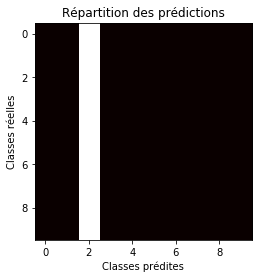

-------------------- Prédictions par chanson --------------------
Global accuracy : 10.00%
Genre 0 : 0.00%
Genre 1 : 0.00%
Genre 2 : 100.00%
Genre 3 : 0.00%
Genre 4 : 0.00%
Genre 5 : 0.00%
Genre 6 : 0.00%
Genre 7 : 0.00%
Genre 8 : 0.00%
Genre 9 : 0.00%


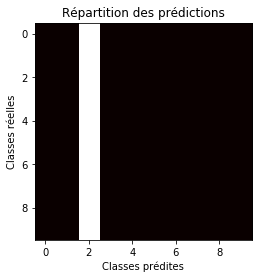

Entrainement et test de prédiction avec SVM (activations de la couche 2 du DBN)
-------------------- Segment par segment --------------------
Global accuracy : 10.00%
Genre 0 : 0.00%
Genre 1 : 0.00%
Genre 2 : 100.00%
Genre 3 : 0.00%
Genre 4 : 0.00%
Genre 5 : 0.00%
Genre 6 : 0.00%
Genre 7 : 0.00%
Genre 8 : 0.00%
Genre 9 : 0.00%


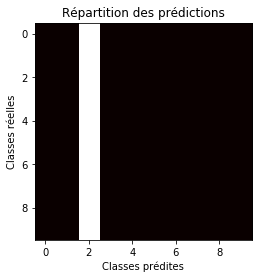

-------------------- Prédictions par chanson --------------------
Global accuracy : 10.00%
Genre 0 : 0.00%
Genre 1 : 0.00%
Genre 2 : 100.00%
Genre 3 : 0.00%
Genre 4 : 0.00%
Genre 5 : 0.00%
Genre 6 : 0.00%
Genre 7 : 0.00%
Genre 8 : 0.00%
Genre 9 : 0.00%


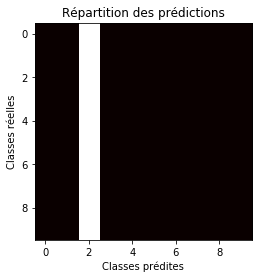

Entrainement et test de prédiction avec SVM (activations de la couche 3 du DBN)
-------------------- Segment par segment --------------------
Global accuracy : 10.00%
Genre 0 : 0.00%
Genre 1 : 0.00%
Genre 2 : 100.00%
Genre 3 : 0.00%
Genre 4 : 0.00%
Genre 5 : 0.00%
Genre 6 : 0.00%
Genre 7 : 0.00%
Genre 8 : 0.00%
Genre 9 : 0.00%


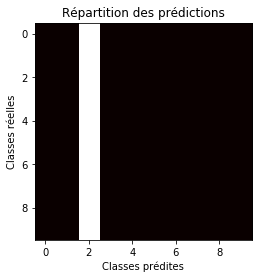

-------------------- Prédictions par chanson --------------------
Global accuracy : 10.00%
Genre 0 : 0.00%
Genre 1 : 0.00%
Genre 2 : 100.00%
Genre 3 : 0.00%
Genre 4 : 0.00%
Genre 5 : 0.00%
Genre 6 : 0.00%
Genre 7 : 0.00%
Genre 8 : 0.00%
Genre 9 : 0.00%


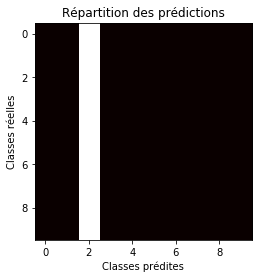

In [0]:
# Test pour chaque numéro de couche du réseau DBN et affichage des résultats
for layer in range(1,4):
  print('='*80)
  print("Entrainement et test de prédiction avec SVM (activations de la couche {} du DBN)".format(layer))
  svm_model = train_svm_dbn(dbn_net, layer, data_train, y_train, 5, 2.5)
  (nb_pred, nb_pred_song) = test_pred_svm_dbn(dbn_net, svm_model, layer, data_test, y_test, 5, 2.5)
  print('-'*20, "Segment par segment", '-'*20)
  show_results(nb_pred)
  print('-'*20, "Prédictions par chanson", '-'*20)
  show_results(nb_pred_song)

## Réseau pleinement connecté (Perceptron multi-couches)

### Création et entrainement

In [0]:
# Création du réseau
mlp_net = MLP(N_FEATURES,[50, 50, 10])
# Entrainement du réseau
(train_losses, train_acc, val_losses, val_acc) = train_model(mlp_net, data_X_train, data_y_train, data_X_val, data_y_val, 20, 500, 0.001, 1e-3)

Epoch:  1 train loss: 1.6398 train acc: 43.85 val loss: 1.4761 val acc: 49.41
Epoch:  2 train loss: 1.4212 train acc: 51.26 val loss: 1.3800 val acc: 52.61
Epoch:  3 train loss: 1.3487 train acc: 53.59 val loss: 1.3339 val acc: 54.07
Epoch:  4 train loss: 1.3068 train acc: 54.89 val loss: 1.3088 val acc: 54.94
Epoch:  5 train loss: 1.2807 train acc: 55.77 val loss: 1.2891 val acc: 55.52
Epoch:  6 train loss: 1.2610 train acc: 56.40 val loss: 1.2767 val acc: 55.92
Epoch:  7 train loss: 1.2464 train acc: 56.89 val loss: 1.2701 val acc: 56.13
Epoch:  8 train loss: 1.2351 train acc: 57.27 val loss: 1.2644 val acc: 56.24
Epoch:  9 train loss: 1.2260 train acc: 57.58 val loss: 1.2601 val acc: 56.27
Epoch:  10 train loss: 1.2181 train acc: 57.77 val loss: 1.2560 val acc: 56.32
Epoch:  11 train loss: 1.2111 train acc: 58.04 val loss: 1.2509 val acc: 56.53
Epoch:  12 train loss: 1.2055 train acc: 58.21 val loss: 1.2487 val acc: 56.52
Epoch:  13 train loss: 1.2008 train acc: 58.36 val loss: 1.24

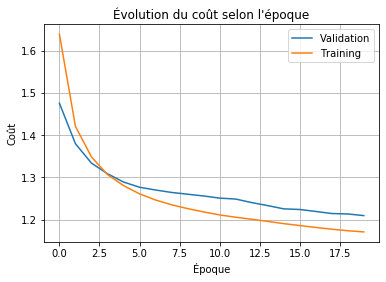

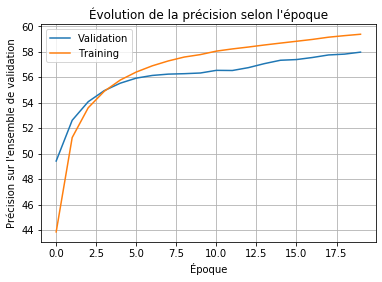

In [0]:
# Affichage des graphiques de cout et de précision selon l'époque pour les données d'entrainement et les données de validation
plt.figure()
plt.plot(np.arange(len(val_losses)), val_losses)
plt.plot(np.arange(len(train_losses)), train_losses)
plt.legend(['Validation', 'Training'])
plt.title("Évolution du coût selon l'époque")
plt.xlabel('Époque')
plt.ylabel('Coût')
plt.grid()

plt.figure()
plt.plot(np.arange(len(val_acc)), val_acc)
plt.plot(np.arange(len(train_acc)), train_acc)
plt.legend(['Validation', 'Training'])
plt.title("Évolution de la précision selon l'époque")
plt.xlabel('Époque')
plt.ylabel("Précision sur l'ensemble de validation")
plt.grid()

plt.show()

### Évaluation de la performance

In [0]:
# Évaluation de la précision globale sur l'ensemble de test
total = 0.
correct = 0.
with torch.no_grad():
  out = mlp_net.forward(data_X_test)
  _, predicted = torch.max(out.data, 1)
  total += data_y_test.size(0)
  correct += predicted.eq(data_y_test.data).cpu().sum()
test_acc = 100.* correct/total
print("Accuracy on test set : {:.2f}%".format(test_acc))

In [0]:
# Évaluation de la précision par genre
nb_pred = np.zeros((10,10))
for i in range(10):
  for j in range(10):
    nb_pred[i,j] = (predicted.eq(j) & data_y_test.eq(i)).cpu().sum()

Global accuracy : 58.20%
Genre 0 | blues | 64.73%
Genre 1 | classical | 88.47%
Genre 2 | country | 50.30%
Genre 3 | disco | 33.80%
Genre 4 | hiphop | 43.08%
Genre 5 | jazz | 68.91%
Genre 6 | metal | 80.83%
Genre 7 | pop | 68.66%
Genre 8 | reggae | 45.34%
Genre 9 | rock | 37.00%


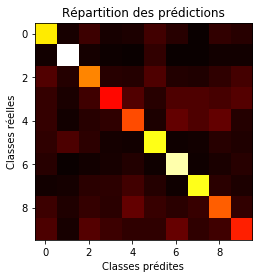

array([64.72583086, 88.46566798, 50.29610176, 33.79653635, 43.07636098,
       68.90512462, 80.82695253, 68.65963468, 45.33775383, 37.00342288])

In [0]:
# Affichage des résultats
show_results(nb_pred)